<a href="https://colab.research.google.com/github/byshadowoz/X07/blob/main/Modelo_Forecaster_bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import datetime

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('ggplot')

# Colores Bitcoin
# ==============================================================================
palette_btc = {'naranja': '#f7931a',
               'blanco' : '#ffffff',
               'gris'   : '#4d4d4d',
               'azul'   : '#0d579b',
               'verde'  : '#329239'
              }

# Modelado y Forecasting
# ==============================================================================
!pip install skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

In [92]:
data = pd.read_csv('bitcoindata.csv')
data = data.loc[::-1].reset_index(drop=True)

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4971 entries, 0 to 4970
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Fecha     4971 non-null   object
 1   Último    4971 non-null   object
 2   Apertura  4971 non-null   object
 3   Máximo    4971 non-null   object
 4   Mínimo    4971 non-null   object
 5   Vol.      4965 non-null   object
 6   % var.    4971 non-null   object
dtypes: object(7)
memory usage: 272.0+ KB


In [94]:
data['date'] = pd.to_datetime(data['Fecha'], format='%d.%m.%Y')

In [95]:
data.drop(columns='Fecha')

,Último,Apertura,Máximo,Mínimo,Vol.,% var.,date
0,"0,1","0,0","0,1","0,1","0,08K","0,00%",2010-07-18
1,"0,1","0,1","0,1","0,1","0,57K","0,00%",2010-07-19
2,"0,1","0,1","0,1","0,1","0,26K","0,00%",2010-07-20
3,"0,1","0,1","0,1","0,1","0,58K","0,00%",2010-07-21
4,"0,1","0,1","0,1","0,1","2,16K","0,00%",2010-07-22
...,...,...,...,...,...,...,...
4966,"51.858,2","52.263,5","52.367,3","50.676,9","59,02K","-0,78%",2024-02-21
4967,"51.320,4","51.850,2","52.015,8","50.947,3","50,27K","-1,04%",2024-02-22
4968,"50.740,5","51.320,6","51.532,5","50.537,6","43,27K","-1,13%",2024-02-23
4969,"51.571,6","50.739,6","51.689,9","50.592,0","20,99K","1,64%",2024-02-24


In [96]:
data

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.,date
0,18.07.2010,"0,1","0,0","0,1","0,1","0,08K","0,00%",2010-07-18
1,19.07.2010,"0,1","0,1","0,1","0,1","0,57K","0,00%",2010-07-19
2,20.07.2010,"0,1","0,1","0,1","0,1","0,26K","0,00%",2010-07-20
3,21.07.2010,"0,1","0,1","0,1","0,1","0,58K","0,00%",2010-07-21
4,22.07.2010,"0,1","0,1","0,1","0,1","2,16K","0,00%",2010-07-22
...,...,...,...,...,...,...,...,...
4966,21.02.2024,"51.858,2","52.263,5","52.367,3","50.676,9","59,02K","-0,78%",2024-02-21
4967,22.02.2024,"51.320,4","51.850,2","52.015,8","50.947,3","50,27K","-1,04%",2024-02-22
4968,23.02.2024,"50.740,5","51.320,6","51.532,5","50.537,6","43,27K","-1,13%",2024-02-23
4969,24.02.2024,"51.571,6","50.739,6","51.689,9","50.592,0","20,99K","1,64%",2024-02-24


In [97]:
# Preparación del dato
# ==============================================================================
data = data.loc[:, ['date', 'Apertura', 'Último', 'Máximo', 'Mínimo']]
data = data.rename({'Apertura': 'open', 'Último': 'close', 'Máximo': 'high', 'Mínimo': 'low'},
                    axis=1)
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()

In [98]:
# Reemplazar los puntos y comas por una cadena vacía
data['open'] = data['open'].str.replace('.', '').str.replace(',', '.').astype(float)
data['close'] = data['close'].str.replace('.', '').str.replace(',', '.').astype(float)
data['high'] = data['high'].str.replace('.', '').str.replace(',', '.').astype(float)
data['low'] = data['low'].str.replace('.', '').str.replace(',', '.').astype(float)

<ipython-input-98-388664e0be40>:2: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

<ipython-input-98-388664e0be40>:3: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

<ipython-input-98-388664e0be40>:4: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

<ipython-input-98-388664e0be40>:5: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



In [99]:
print(f'Número de filas con missing values: {data.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


In [100]:
data

,open,close,high,low
date,,,,
2010-07-18,0.0,0.1,0.1,0.1
2010-07-19,0.1,0.1,0.1,0.1
2010-07-20,0.1,0.1,0.1,0.1
2010-07-21,0.1,0.1,0.1,0.1
2010-07-22,0.1,0.1,0.1,0.1
...,...,...,...,...
2024-02-21,52263.5,51858.2,52367.3,50676.9
2024-02-22,51850.2,51320.4,52015.8,50947.3
2024-02-23,51320.6,50740.5,51532.5,50537.6


In [101]:
btc_halving = {'halving'              : [0, 1 , 2, 3, 4],
               'date'                 : ['2009-01-03', '2012-11-28',
                                         '2016-07-09', '2020-05-11', '2024-04-20'],
               'reward'               : [50, 25, 12.5, 6.25, 3.125],
               'halving_block_number' : [0, 210000, 420000 ,630000, 840000]
              }

In [102]:
# Incluir recompensas y cuenta regresiva para próximo halving en el dataset
# ==============================================================================
data['reward'] = np.nan
data['countdown_halving'] = np.nan

for i in range(len(btc_halving['halving'])-1):

    # Fecha inicial y final de cada halving
    if btc_halving['date'][i] < data.index.min().strftime('%Y-%m-%d'):
        start_date = data.index.min().strftime('%Y-%m-%d')
    else:
        start_date = btc_halving['date'][i]

    end_date = btc_halving['date'][i+1]
    mask = (data.index >= start_date) & (data.index < end_date)

    # Rellenar columna 'reward' con las recompensas de minería
    data.loc[mask, 'reward'] = btc_halving['reward'][i]

    # Rellenar columna 'countdown_halving' con los días restantes
    time_to_next_halving = pd.to_datetime(end_date) - pd.to_datetime(start_date)

    data.loc[mask, 'countdown_halving'] = np.arange(time_to_next_halving.days)[::-1][:mask.sum()]

In [103]:
# Comprobar que se han creado los datos correctamente
# ==============================================================================
print('Segundo halving:', btc_halving['date'][2])
display(data.loc['2016-07-08':'2016-07-09'])
print('')
print('Tercer halving:', btc_halving['date'][3])
display(data.loc['2020-05-10':'2020-05-11'])
print('')
print('Próximo halving:', btc_halving['date'][4])
data.tail(2)

Segundo halving: 2016-07-09


,open,close,high,low,reward,countdown_halving
date,,,,,,
2016-07-08,635.3,662.8,663.4,630.2,25.0,0.0
2016-07-09,662.8,651.8,663.5,620.7,12.5,1401.0



Tercer halving: 2020-05-11


,open,close,high,low,reward,countdown_halving
date,,,,,,
2020-05-10,9553.9,8738.8,9569.4,8259.3,12.50,0.0
2020-05-11,8737.6,8579.8,9129.6,8235.6,6.25,1439.0



Próximo halving: 2024-04-20


,open,close,high,low,reward,countdown_halving
date,,,,,,
2024-02-24,50739.6,51571.6,51689.9,50592.0,6.25,55.0
2024-02-25,51572.1,51722.7,51952.0,51299.0,6.25,54.0


In [104]:
data

,open,close,high,low,reward,countdown_halving
date,,,,,,
2010-07-18,0.0,0.1,0.1,0.1,50.00,863.0
2010-07-19,0.1,0.1,0.1,0.1,50.00,862.0
2010-07-20,0.1,0.1,0.1,0.1,50.00,861.0
2010-07-21,0.1,0.1,0.1,0.1,50.00,860.0
2010-07-22,0.1,0.1,0.1,0.1,50.00,859.0
...,...,...,...,...,...,...
2024-02-21,52263.5,51858.2,52367.3,50676.9,6.25,58.0
2024-02-22,51850.2,51320.4,52015.8,50947.3,6.25,57.0
2024-02-23,51320.6,50740.5,51532.5,50537.6,6.25,56.0


In [105]:
# Gráfico de velas japonesas interactivo con Plotly
# ==============================================================================
candlestick = go.Candlestick(
                  x     = data.index,
                  open  = data.open,
                  close = data.close,
                  low   = data.low,
                  high  = data.high,
              )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 900,
    height      = 450,
    title       = dict(text='<b>Chart Bitcoin/USD</b>', font=dict(size=30)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=15)),
    margin      = dict(l=10, r=20, t=80, b=20),
    shapes      = [dict(x0=btc_halving['date'][2], x1=btc_halving['date'][2],
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][3], x1=btc_halving['date'][3],
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][4], x1=btc_halving['date'][4],
                        y0=0, y1=1, xref='x', yref='paper', line_width=2)
                  ],
    annotations = [dict(x=btc_halving['date'][2], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Segundo halving'),
                   dict(x=btc_halving['date'][3], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Tercer halving'),
                   dict(x=btc_halving['date'][4], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Cuarto halving')
                  ],
    xaxis_rangeslider_visible = False,
)
fig.show()

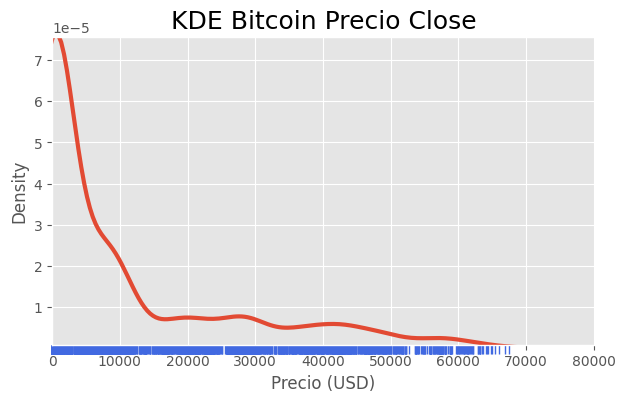

In [106]:
# Distribución KDE del precio de cierre del Bitcoin
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 4))
p = sns.kdeplot(data=data, x='close', linewidth=3, ax=ax)
r = sns.rugplot(data=data, x='close', ax=ax, c='royalblue',
                height=-.03, clip_on=False)
p.set(xlim=(0, None))
p.set_title('KDE Bitcoin Precio Close', fontsize=18)
p.set_xlabel('Precio (USD)');

In [107]:
# Se localizan los datos correspondientes para cada año
# ==============================================================================
years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:

    year_open  = data.loc[data.index.year == year, 'open'][0]
    year_close = data.loc[data.index.year == year, 'close'][-1]
    year_low   = data.loc[data.index.year == year, 'low'].min()
    year_high  = data.loc[data.index.year == year, 'high'].max()

    df_plot[year] = pd.Series([year_open, year_close, year_low, year_high])

df_plot = df_plot.T
df_plot = df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1)

# Se calcula el % de cambio entre el open y el close del año
# ==============================================================================
df_plot['year_change'] = 100*(df_plot['close'] - df_plot['open']) / df_plot['open']
df_plot.head(3)

,open,close,low,high,year_change
2010,0.0,0.3,0.0,0.5,inf
2011,0.3,4.7,0.3,31.9,1466.666667
2012,4.7,13.5,3.9,15.4,187.234043


In [108]:
# Se crea una lista de dicts con las anotaciones de % de cambio para el gráfico
# ==============================================================================
annotations_list = []
max_high = df_plot['high'].max()

for year in years:

    df_aux = df_plot.loc[df_plot.index == year,]
    loc_x  = pd.to_datetime(df_aux.index[0], format='%Y')
    loc_y  = df_aux['high'].values[0]/max_high + 0.05
    text   = '{:.1f}%'.format(df_aux['year_change'].values[0])

    annotation = dict(x=loc_x, y=loc_y,
                      xref='x', yref='paper',
                      showarrow=False, xanchor='center',
                      text=text)

    annotations_list.append(annotation)

# Gráfico de velas japonesas anual interactivo con Plotly
# ==============================================================================
candlestick = go.Candlestick(
                  x     = pd.to_datetime(df_plot.index, format='%Y'),
                  open  = df_plot.open,
                  close = df_plot.close,
                  low   = df_plot.low,
                  high  = df_plot.high
              )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 800,
    height      = 350,
    title       = dict(text='<b>Chart Bitcoin/USD por año</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20),
    xaxis_rangeslider_visible = False,
    annotations = annotations_list
)


In [111]:
# Se localizan los datos correspondientes para cada mes
# ==============================================================================
years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    for mes in range(12):

        start_date = pd.to_datetime(f'{year}-{mes+1}-01', format='%Y-%m-%d')
        end_date = (start_date + pd.offsets.MonthBegin())
        mask = (data.index >= start_date) & (data.index < end_date)

        if not data.loc[mask, :].empty:

            month_open  = data.loc[mask, 'open'][0]
            month_close = data.loc[mask, 'close'][-1]
            month_low   = data.loc[mask, 'low'].min()
            month_high  = data.loc[mask, 'high'].max()

            serie  = pd.Series([month_open, month_close, month_low, month_high])
            df_aux = pd.DataFrame(serie, columns=[f'{str(mes+1).zfill(2)}-{year}'])

            if df_plot.empty:
                df_plot = df_aux.copy()
            else:
                df_plot = pd.concat([df_plot, df_aux], axis=1)

df_plot = df_plot.T
df_plot = df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1)


In [112]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
# df_plot['mes'] = pd.to_datetime(df_plot.index, format='%m-%Y').month
# fig, ax = plt.subplots(figsize=(7, 3.5))
# df_plot.boxplot(column='close', by='mes', ax=ax)
# df_plot.groupby('mes')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Precio (USD)')
# ax.set_title('BTC Precio por mes')
# fig.suptitle('');

df_plot['mes'] = pd.to_datetime(df_plot.index, format='%m-%Y').month

# fig 1 boxplot de los meses
fig1 = px.box(df_plot.sort_values('mes'), x='mes', y='close',
              color_discrete_sequence=[palette_btc['verde']])

# fig 2 line con datos de la mediana de cada mes
df_median = pd.DataFrame(df_plot.groupby('mes')['close'].median()).reset_index()
fig2 = px.line(df_median, x='mes', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gris']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>BTC Precio por mes</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='mes', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()

In [113]:
# Gráfico boxplot para estacionalidad mensual
# ==============================================================================
# fig, ax = plt.subplots(figsize=(9, 3.5))
# data['dia_mes'] = pd.Series(data.index).dt.day.values
# data.boxplot(column='close', by='dia_mes', ax=ax)
# data.groupby('dia_mes')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Precio (USD)')
# ax.set_title('BTC Precio por día del mes')
# fig.suptitle('');

data['dia_mes'] = pd.Series(data.index).dt.day.values

# fig 1 boxplot de los días del mes
fig1 = px.box(data.sort_values('dia_mes'), x='dia_mes', y='close',
              color_discrete_sequence=[palette_btc['verde']])

# fig 2 line con datos de la mediana de los días del mes
df_median = pd.DataFrame(data.groupby('dia_mes')['close'].median()).reset_index()
fig2 = px.line(df_median, x='dia_mes', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gris']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 750,
    height      = 350,
    title       = dict(text='<b>BTC Precio por día del mes</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear', tickangle=0, range=[0.5, 31.5]),
    xaxis_title = dict(text='día', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()

In [114]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
# fig, ax = plt.subplots(figsize=(7, 3.5))
# data['dia_semana'] = data.index.day_of_week + 1
# data.boxplot(column='close', by='dia_semana', ax=ax)
# data.groupby('dia_semana')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Precio (USD)')
# ax.set_title('BTC Precio por día de la semana');

data['dia_semana'] = data.index.day_of_week + 1

# fig 1 boxplot de los días de la semana
fig1 = px.box(data.sort_values('dia_semana'), x='dia_semana', y='close',
              color_discrete_sequence=[palette_btc['verde']])

# fig 2 line con datos de la mediana los días de la semana
df_median = pd.DataFrame(data.groupby('dia_semana')['close'].median()).reset_index()
fig2 = px.line(df_median, x='dia_semana', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gris']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>BTC Precio por día de la semana</b>', font=dict(size=25)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='día de la semana', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()


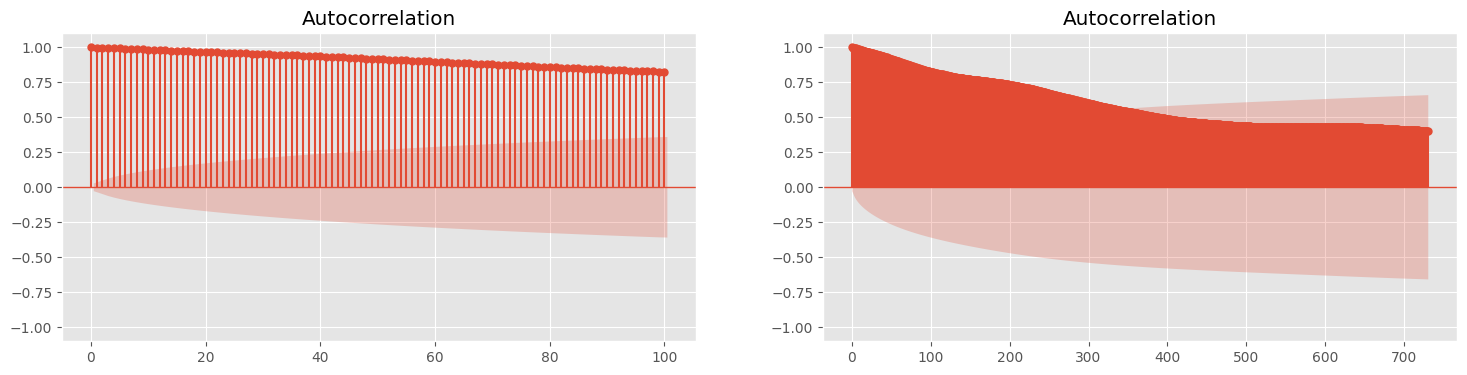

In [115]:
# Gráfico autocorrelación
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_acf(data.close, ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(data.close, ax=axes[1], linewidth = 1, lags=730)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

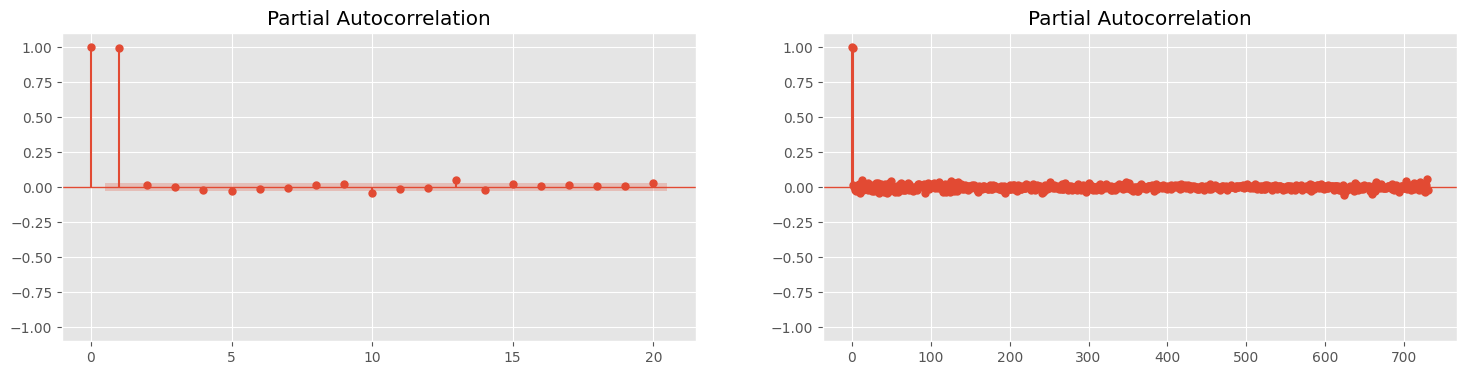

In [116]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_pacf(data.close, ax=axes[0], lags=20, method='ywm',  linewidth = 1)
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(data.close, ax=axes[1], lags=730, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

In [117]:
# Selección fechas train-test
# ==============================================================================
inicio_train = '2020-01-01 00:00:00'
fin_train = '2021-06-30 23:59:59'

print(f"Serie temporal completa : {data.index.min()} --- {data.index.max()}  (n={len(data)})")
print(f"Fechas train            : {data.loc[inicio_train:fin_train].index.min()} --- {data.loc[inicio_train:fin_train].index.max()}  (n={len(data.loc[inicio_train:fin_train])})")
print(f"Fechas test             : {data.loc[fin_train:].index.min()} --- {data.loc[fin_train:].index.max()}  (n={len(data.loc[fin_train:])})")

Serie temporal completa : 2010-07-18 00:00:00 --- 2024-02-25 00:00:00  (n=4971)
Fechas train            : 2020-01-01 00:00:00 --- 2021-06-30 00:00:00  (n=547)
Fechas test             : 2021-07-01 00:00:00 --- 2024-02-25 00:00:00  (n=970)


In [118]:
# Simulación Random Walk
# ==============================================================================
df_rw = data[['close']].copy()
df_rw['pred_close'] = df_rw['close'].shift(1)

# Error de test
# ==============================================================================
y_true = df_rw.loc[fin_train:, 'close']
y_pred = df_rw.loc[fin_train:, 'pred_close']
metrica = mean_absolute_error(y_true, y_pred)

print(f'Error de test: {metrica}')
display(df_rw.loc[fin_train:,].head(4))


Error de test: 701.4175257731958


,close,pred_close
date,,
2021-07-01,33543.6,35026.9
2021-07-02,33813.4,33543.6
2021-07-03,34742.8,33813.4
2021-07-04,35298.2,34742.8


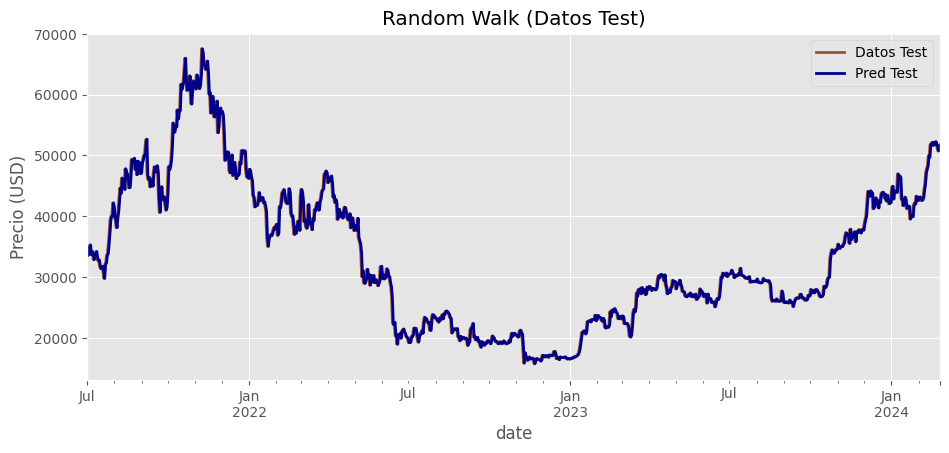

In [119]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4.5))
df_rw.loc[fin_train:, 'close'].plot(ax=ax, linewidth=2, label='Datos Test',
                                    c='sienna')
df_rw.loc[fin_train:, 'pred_close'].plot(ax=ax, linewidth=2, label='Pred Test',
                                    c='darkblue')
ax.set_title('Random Walk (Datos Test)')
ax.set_ylabel('Precio (USD)')
ax.legend();

In [120]:
# DataFrame errores test modelos
# ==============================================================================
df_errores = pd.DataFrame({'modelo': 'Base - Random Walk', 'lags': 1,
                           'error_test': metrica, 'variables_exog': False},
                          index=[0])
df_errores

,modelo,lags,error_test,variables_exog
0,Base - Random Walk,1,701.417526,False


In [121]:
# Backtest forecasters con diferentes lags
# ==============================================================================
lags = [1, 7, 30]
metricas = []
predicciones_list = []

for lag in lags:

    # Crear forecaster
    forecaster = ForecasterAutoreg(
                     regressor     = LGBMRegressor(random_state=123),
                     lags          = lag,
                     transformer_y = None
                 )

    # Backtest test data 1 step
    metrica, predicciones = backtesting_forecaster(
                                forecaster         = forecaster,
                                y                  = data.loc[inicio_train:, 'close'],
                                initial_train_size = len(data.loc[inicio_train:fin_train, 'close']),
                                fixed_train_size   = True,
                                steps              = 1,
                                refit              = True,
                                metric             = 'mean_absolute_error',
                                verbose            = False
                            )

    metricas.append(metrica)
    predicciones_list.append(predicciones)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 183
[LightGBM] [Info] Number of data points in the train set: 546, number of used features: 1
[LightGBM] [Info] Start training from score 22637.509888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.10/dist-packages/skforecast/model_selection/model_selection.py:548: LongTrainingWarning:

The forecaster will be fit 970 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)



  0%|          | 0/970 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1267
[LightGBM] [Info] Number of data points in the train set: 540, number of used features: 7
[LightGBM] [Info] Start training from score 22805.752220
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.10/dist-packages/skforecast/model_selection/model_selection.py:548: LongTrainingWarning:

The forecaster will be fit 970 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)



  0%|          | 0/970 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5190
[LightGBM] [Info] Number of data points in the train set: 517, number of used features: 30
[LightGBM] [Info] Start training from score 23436.917794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.10/dist-packages/skforecast/model_selection/model_selection.py:548: LongTrainingWarning:

The forecaster will be fit 970 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)



  0%|          | 0/970 [00:00<?, ?it/s]

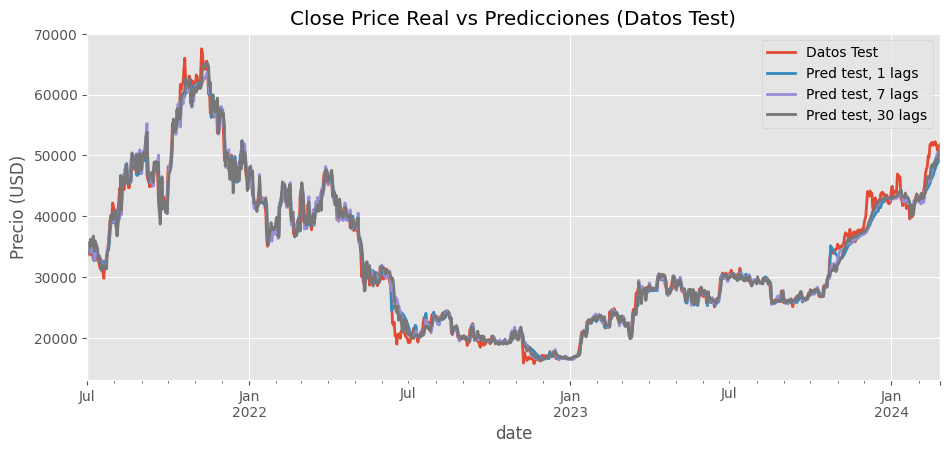

In [123]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4.5))
data.loc[fin_train:, 'close'].plot(ax=ax, linewidth=2, label='Datos Test')

# Plot predicciones test para diferentes lags
for predicciones, lag in zip(predicciones_list, lags):
    predicciones = predicciones.rename(columns={'pred': f'Pred test, {lag} lags'})
    predicciones.plot(ax=ax, linewidth=2)

ax.set_title('Close Price Real vs Predicciones (Datos Test)')
ax.set_ylabel('Precio (USD)')
ax.legend();

In [124]:
# DataFrame errores de test modelos
# ==============================================================================
modelo = 'LGBMRegressor'

df_errores = pd.concat([
                df_errores,
                pd.DataFrame({'modelo': modelo, 'lags': lags,
                              'error_test': metricas, 'variables_exog': False})
                ]).reset_index(drop=True)

df_errores.sort_values(by='error_test')

,modelo,lags,error_test,variables_exog
0,Base - Random Walk,1,701.417526,False
2,LGBMRegressor,7,1043.208392,False
5,LGBMRegressor,7,1043.208392,False
1,LGBMRegressor,1,1043.961677,False
4,LGBMRegressor,1,1043.961677,False
3,LGBMRegressor,30,1056.949381,False
6,LGBMRegressor,30,1056.949381,False


In [125]:
# Cambio de las variables categóricas a tipo category
# ==============================================================================
data['mes'] = data.index.month
data['mes'] = data['mes'].astype('category')
data['reward'] = data['reward'].astype('category')

# One hot encoding
data = pd.get_dummies(data, columns=['reward', 'mes'])
data.head(2)

,open,close,high,low,countdown_halving,dia_mes,dia_semana,reward_6.25,reward_12.5,reward_25.0,...,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
date,,,,,,,,,,,,,,,,,,,,,
2010-07-18,0.0,0.1,0.1,0.1,863.0,18,7,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2010-07-19,0.1,0.1,0.1,0.1,862.0,19,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [126]:
# Se seleccionan todas las variables exógenas, incluidas las obtenidas al hacer
# el one hot encoding
# ==============================================================================
exog = [column for column in data.columns if column.startswith(('reward', 'mes'))]
exog.extend(['countdown_halving'])
print(exog)

['reward_6.25', 'reward_12.5', 'reward_25.0', 'reward_50.0', 'mes_1', 'mes_2', 'mes_3', 'mes_4', 'mes_5', 'mes_6', 'mes_7', 'mes_8', 'mes_9', 'mes_10', 'mes_11', 'mes_12', 'countdown_halving']


In [127]:
# Backtest forecaster con variables exógenas
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = LGBMRegressor(random_state=123),
                 lags             = 1,
                 transformer_y    = None,
                 transformer_exog = None
             )

# Backtest test data 1 step
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data.loc[inicio_train:, 'close'],
                            exog               = data.loc[inicio_train:, exog],
                            initial_train_size = len(data.loc[inicio_train:fin_train, 'close']),
                            fixed_train_size   = True,
                            steps              = 1,
                            refit              = True,
                            metric             = 'mean_absolute_error',
                            verbose            = False
                        )

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 393
[LightGBM] [Info] Number of data points in the train set: 546, number of used features: 16
[LightGBM] [Info] Start training from score 22637.509888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.10/dist-packages/skforecast/model_selection/model_selection.py:548: LongTrainingWarning:

The forecaster will be fit 970 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)



  0%|          | 0/970 [00:00<?, ?it/s]

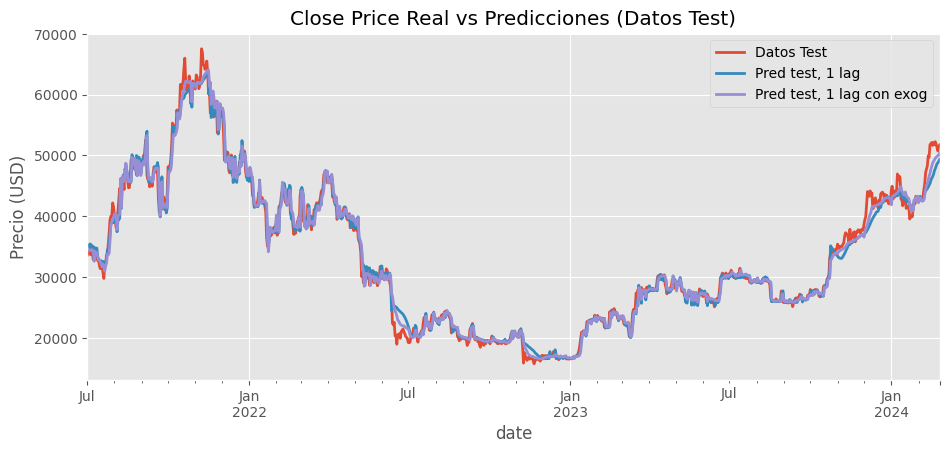

In [128]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4.5))
data.loc[fin_train:, 'close'].plot(ax=ax, linewidth=2, label='Datos Test')

# Plot predicciones 1 lag sin variables exógenas
predicciones_no_exog = predicciones_list[0].rename(columns={'pred': f'Pred test, 1 lag'})
predicciones_no_exog.plot(ax=ax, linewidth=2)

# Plot predicciones 1 lag con variables exógenas
predicciones_exog = predicciones.rename(columns={'pred': f'Pred test, 1 lag con exog'})
predicciones_exog.plot(ax=ax, linewidth=2)

ax.set_title('Close Price Real vs Predicciones (Datos Test)')
ax.set_ylabel('Precio (USD)')
ax.legend();

In [129]:
# DataFrame errores de test modelos
# ==============================================================================
modelo = 'LGBMRegressor'

df_errores = pd.concat([
                df_errores,
                pd.DataFrame({'modelo': modelo, 'lags': 1,
                              'error_test': metrica, 'variables_exog': True},
                             index=[4])
                ]).reset_index(drop=True)

df_errores.sort_values(by='error_test')

,modelo,lags,error_test,variables_exog
0,Base - Random Walk,1,701.417526,False
7,LGBMRegressor,1,935.231413,True
2,LGBMRegressor,7,1043.208392,False
5,LGBMRegressor,7,1043.208392,False
1,LGBMRegressor,1,1043.961677,False
4,LGBMRegressor,1,1043.961677,False
3,LGBMRegressor,30,1056.949381,False
6,LGBMRegressor,30,1056.949381,False


ModuleNotFoundError: No module named 'session_info'